# Using Bert as a email classifier

In [ ]:
Print("Bert file")

In [ ]:
# ===================== COMPLETE BERT-BASED ATS EMAIL CLASSIFIER =====================
# Copy–Paste Ready | Includes EarlyStopping, ReduceLROnPlateau, Class Weights,
# Dataset Balancing, Stratified Splits, Overfitting Controls, and Safe BERT Loading
# ==================================================================================

# ---------- STEP 0: IMPORT LIBRARIES ----------
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from transformers import BertTokenizerFast, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# ---------- STEP 1: LOAD & CLEAN DATA ----------
df = pd.read_csv("final_training_data1.csv")
df.columns = ["label", "text"]

df = df.dropna(subset=["label", "text"])
df = df.drop_duplicates(subset=["text"])
df = df.sample(frac=1, random_state=42)

print("Original Class Distribution:")
print(df["label"].value_counts())


# ---------- STEP 2: BALANCE DATASET (ANTI-IMBALANCE) ----------
df_balanced = df.groupby("label").apply(
    lambda x: x.sample(min(len(x), 450), random_state=42)
).reset_index(drop=True)

print("\nBalanced Class Distribution:")
print(df_balanced["label"].value_counts())


# ---------- STEP 3: LABEL ENCODING ----------
label_encoder = LabelEncoder()
df_balanced["label_encoded"] = label_encoder.fit_transform(df_balanced["label"])

num_classes = df_balanced["label_encoded"].nunique()
print("\nClasses:", label_encoder.classes_)


# ---------- STEP 4: TRAIN / VAL / TEST SPLIT (STRATIFIED) ----------
X_train, X_temp, y_train, y_temp = train_test_split(
    df_balanced["text"],
    df_balanced["label_encoded"],
    test_size=0.3,
    stratify=df_balanced["label_encoded"],
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.33,
    stratify=y_temp,
    random_state=42
)

print(f"\nTrain: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")


# ---------- STEP 5: LOAD BERT TOKENIZER ----------
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")


# ---------- STEP 6: TOKENIZATION FUNCTION ----------
def bert_encode(texts, tokenizer, max_len=256):
    return tokenizer(
        texts.tolist(),
        padding=True,
        truncation=True,
        max_length=max_len,
        return_tensors="tf"
    )

train_enc = bert_encode(X_train, tokenizer)
val_enc   = bert_encode(X_val, tokenizer)
test_enc  = bert_encode(X_test, tokenizer)


# ---------- STEP 7: CLASS WEIGHTS (ANTI-IMBALANCE) ----------
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))
print("\nClass Weights:", class_weight_dict)


# ---------- STEP 8: LOAD BERT MODEL (SAFE LOAD FIX) ----------
model = TFBertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_classes,
    from_pt=True  # fixes safetensors / safe_open error
)


# ---------- STEP 9: COMPILE MODEL (LOW LR = LESS OVERFITTING) ----------
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)



model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)


# ---------- STEP 10: CALLBACKS ----------
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=1,
    min_lr=1e-7,
    verbose=1
)


# ---------- STEP 11: TRAIN MODEL ----------
history = model.fit(
    dict(train_enc),
    y_train,
    validation_data=(dict(val_enc), y_val),
    epochs=5,          # BERT converges fast
    batch_size=16,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


# ---------- STEP 12: EVALUATE ON TEST SET ----------
test_preds = model.predict(dict(test_enc))
y_pred = np.argmax(test_preds.logits, axis=1)

print("\n--- Classification Report ---")
print(classification_report(
    y_test,
    y_pred,
    target_names=label_encoder.classes_,
    digits=4
))


# ---------- STEP 13: CONFUSION MATRIX ----------
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# ---------- STEP 14: TRAINING CURVES ----------
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.legend()
plt.title("Accuracy")

plt.show()


# ---------- STEP 15: CONFIDENCE-AWARE PREDICTION ----------
def predict_email(text, threshold=0.7):
    enc = tokenizer(
        text,
        return_tensors="tf",
        truncation=True,
        padding=True,
        max_length=256
    )

    logits = model(enc).logits
    probs = tf.nn.softmax(logits, axis=1)
    idx = tf.argmax(probs, axis=1).numpy()[0]
    confidence = float(probs[0][idx])

    result = {
        "predicted_class": label_encoder.classes_[idx],
        "confidence": confidence
    }

    if confidence < threshold:
        result["warning"] = "Low confidence prediction"

    return result


# ---------- STEP 16: SAMPLE PREDICTION ----------
print(predict_email("Dear HR, I am applying for the Data Scientist position."))


# ---------- STEP 17: SAVE MODEL & TOKENIZER ----------
model.save("bert_ats_model1")
tokenizer.save_pretrained("bert_ats_tokenizer1")

# ===================== END OF COMPLETE CODE =====================


# Output images


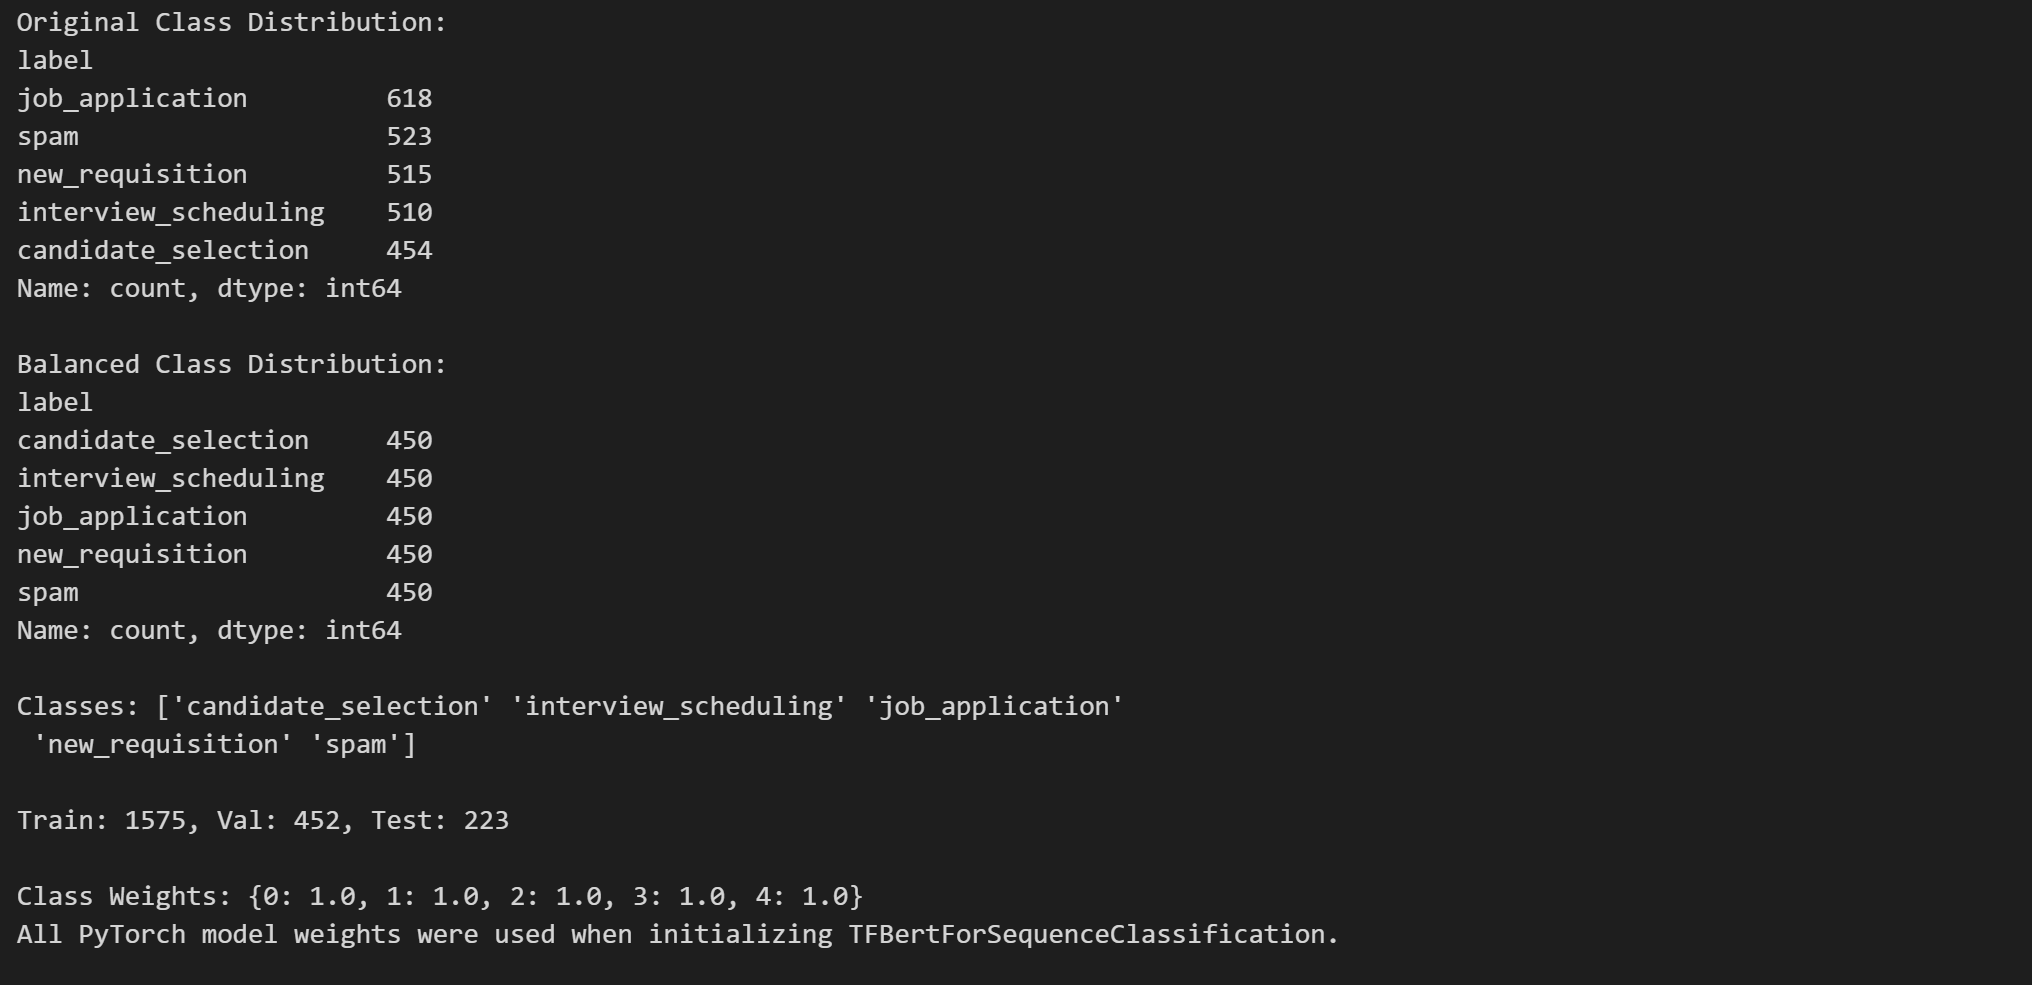

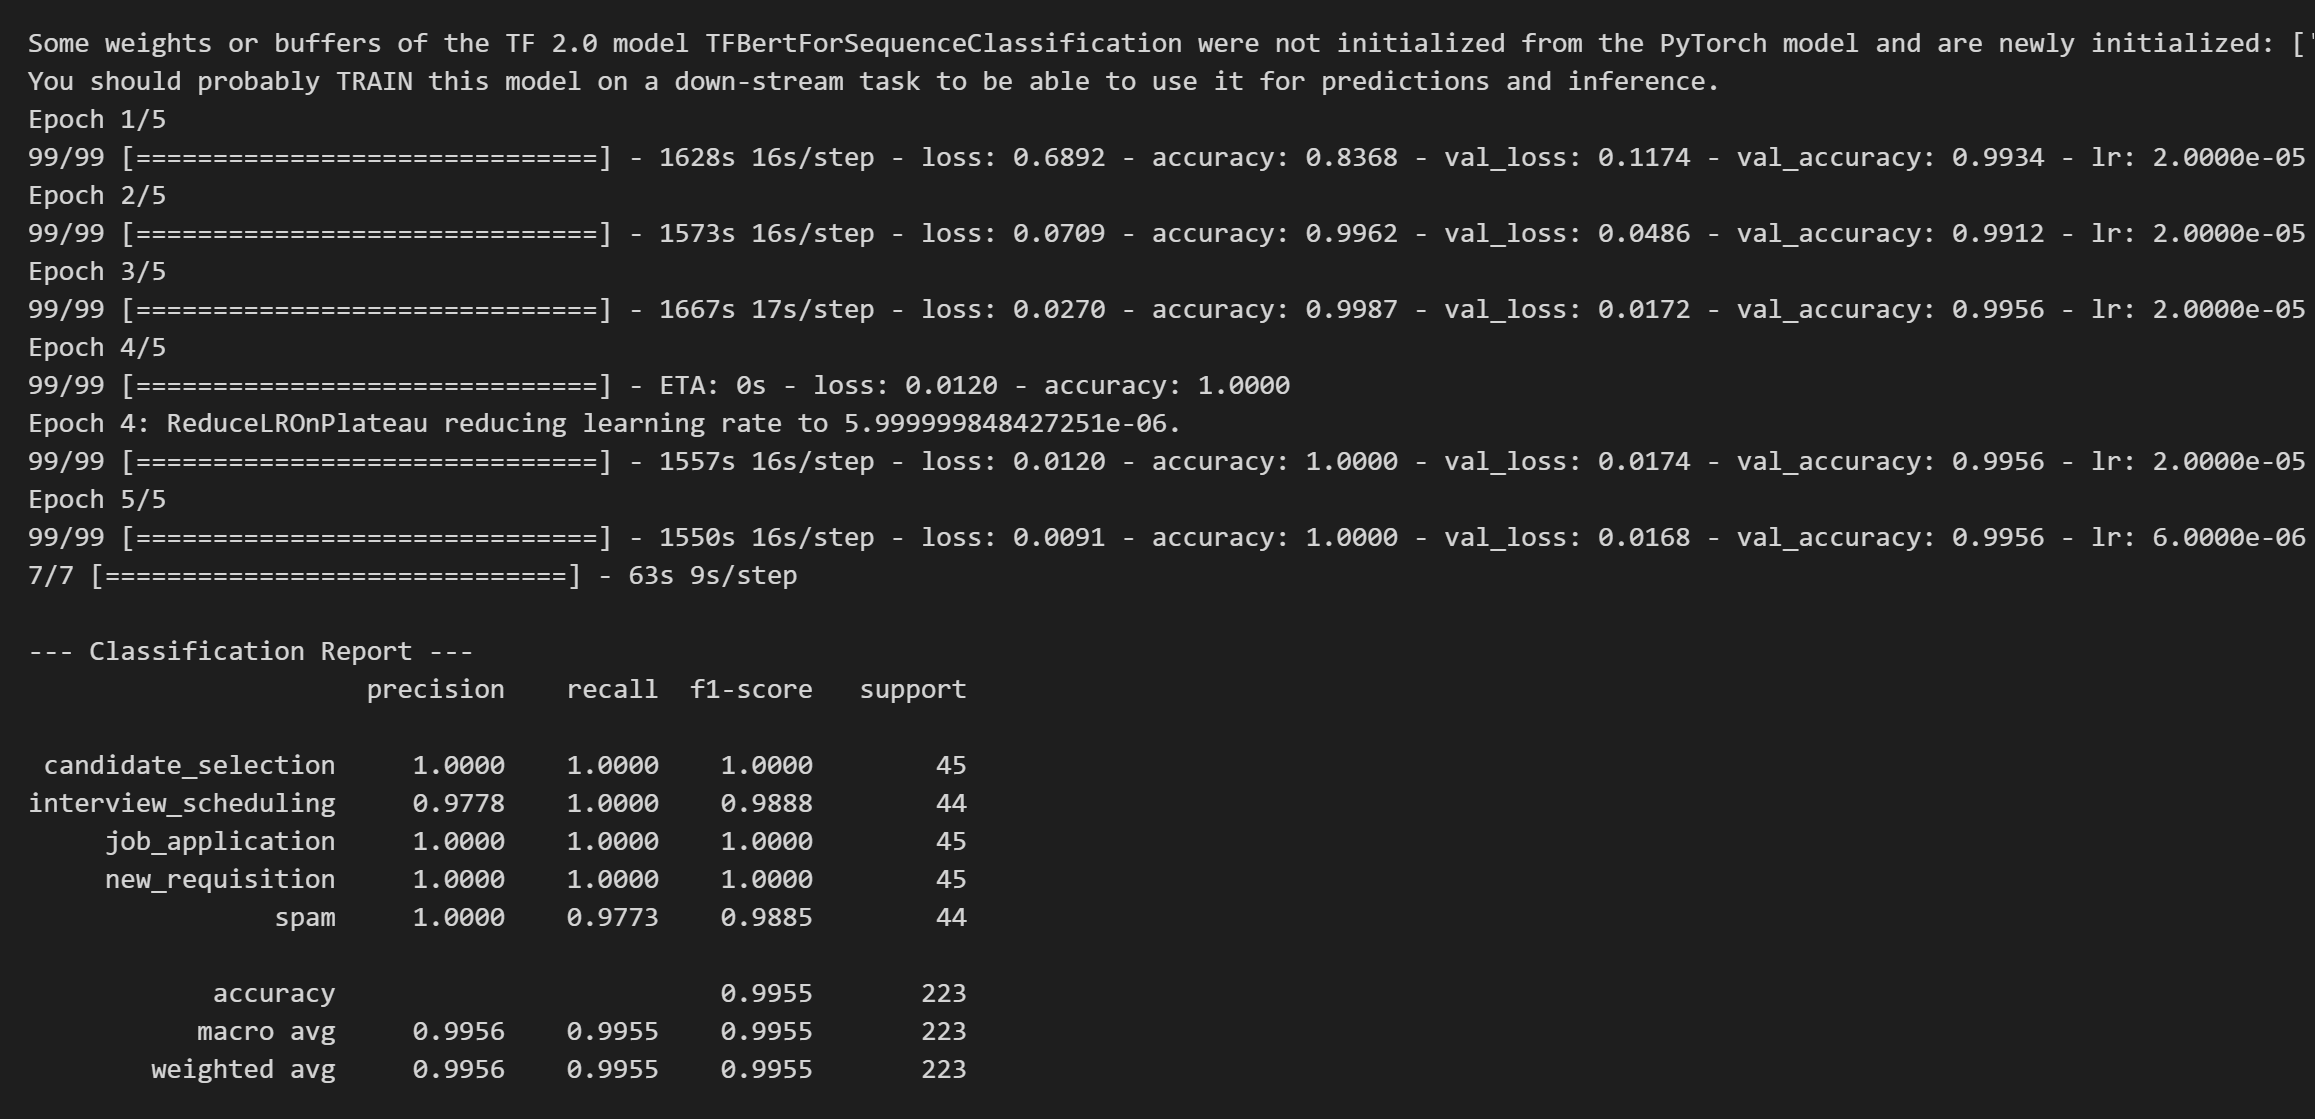

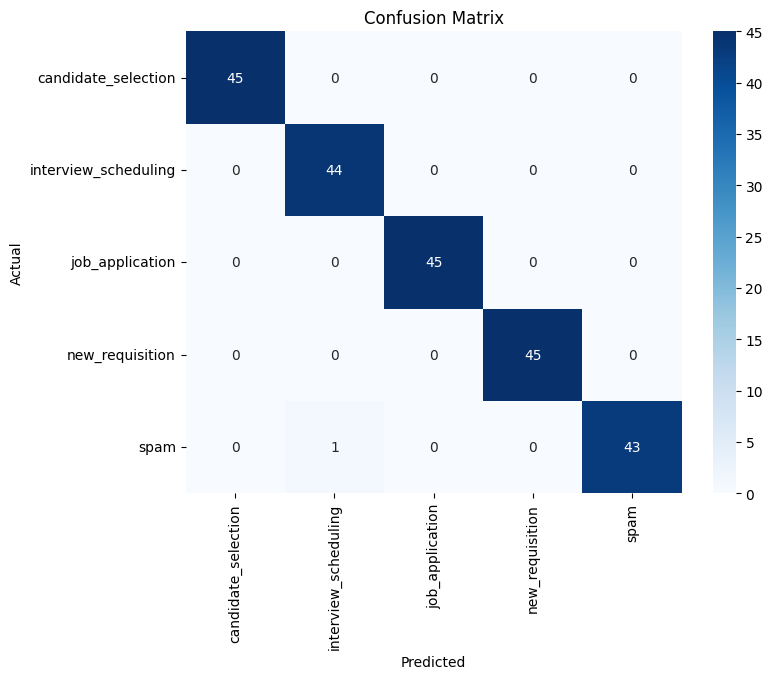

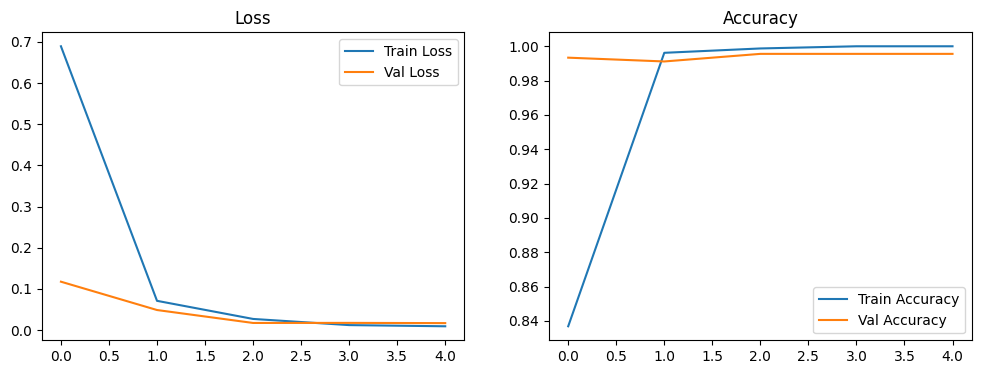

In [ ]:
sample_email = """Subject: 🚨 Urgent! Your Account Has Been Compromised – Verify Now

Dear Customer,

We detected suspicious activity on your account. For your safety, we have temporarily limited access to your account.

To restore full access, please verify your details immediately by clicking the secure link below:

👉 Verify Your Account Now

Failure to verify within 24 hours may result in permanent suspension of your account.

Thank you for your prompt attention.

Sincerely,
Security Team
Customer Support Department"""
print(predict_email(sample_email))


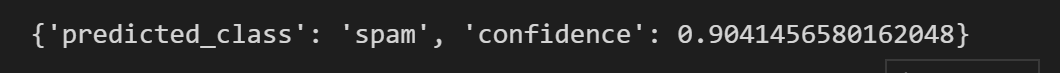

In [ ]:
# ---------------- SAMPLE EMAILS FOR EACH CATEGORY ----------------

sample_emails = {
    "job_application": [
        "Dear HR, I am writing to apply for the Data Scientist position at your organization.",
        "Please find attached my resume for the Software Engineer role.",
        "I am interested in the open Machine Learning Engineer position and would like to apply."
    ],

    "interview_scheduling": [
        "Dear Candidate, your interview is scheduled for Monday at 11 AM. Please confirm.",
        "We would like to schedule a technical interview for the next round.",
        "Kindly let us know your availability for the interview this week."
    ],

    "candidate_selection": [
        "Congratulations! You have been selected for the Data Analyst role.",
        "We are pleased to inform you that you have cleared all interview rounds.",
        "You have been shortlisted and selected. Our HR team will contact you shortly."
    ],

    "spam": [
        "URGENT!!! You have won a free iPhone. Click here to claim now!",
        "Congratulations, you are selected for a cash prize. Act fast!",
        "Limited time offer!!! Earn money from home with zero investment."
    ]
}

# ---------------- RUN PREDICTIONS ----------------

for category, emails in sample_emails.items():
    print(f"\n================ CATEGORY: {category.upper()} ================")
    
    for email in emails:
        result = predict_email(email)
        print(f"\nEmail: {email}")
        print(f"Prediction: {result}")



================ CATEGORY: JOB_APPLICATION ================

Email: Dear HR, I am writing to apply for the Data Scientist position at your organization.
Prediction: {'predicted_class': 'job_application', 'confidence': 0.9850926995277405}

Email: Please find attached my resume for the Software Engineer role.
Prediction: {'predicted_class': 'job_application', 'confidence': 0.9893084764480591}

Email: I am interested in the open Machine Learning Engineer position and would like to apply.
Prediction: {'predicted_class': 'job_application', 'confidence': 0.9758139252662659}

================ CATEGORY: INTERVIEW_SCHEDULING ================

Email: Dear Candidate, your interview is scheduled for Monday at 11 AM. Please confirm.
Prediction: {'predicted_class': 'interview_scheduling', 'confidence': 0.9063847661018372}

Email: We would like to schedule a technical interview for the next round.
Prediction: {'predicted_class': 'spam', 'confidence': 0.4196885824203491, 'warning': 'Low confidence prediction'}

Email: Kindly let us know your availability for the interview this week.
Prediction: {'predicted_class': 'candidate_selection', 'confidence': 0.8914213180541992}

================ CATEGORY: CANDIDATE_SELECTION ================

Email: Congratulations! You have been selected for the Data Analyst role.
Prediction: {'predicted_class': 'candidate_selection', 'confidence': 0.7146317958831787}

Email: We are pleased to inform you that you have cleared all interview rounds.
Prediction: {'predicted_class': 'candidate_selection', 'confidence': 0.8394487500190735}

Email: You have been shortlisted and selected. Our HR team will contact you shortly.
Prediction: {'predicted_class': 'candidate_selection', 'confidence': 0.5683006644248962, 'warning': 'Low confidence prediction'}

================ CATEGORY: SPAM ================

Email: URGENT!!! You have won a free iPhone. Click here to claim now!
Prediction: {'predicted_class': 'spam', 'confidence': 0.9899371862411499}

Email: Congratulations, you are selected for a cash prize. Act fast!
Prediction: {'predicted_class': 'spam', 'confidence': 0.9864894151687622}

Email: Limited time offer!!! Earn money from home with zero investment.
Prediction: {'predicted_class': 'spam', 'confidence': 0.9747705459594727}